In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import joblib
import random
import numpy as np
from scipy.stats import linregress
import torch
from matplotlib import pyplot as plt
from syd import make_viewer
from tqdm import tqdm
from rastermap import Rastermap
import optuna

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, sort_by_preferred_environment, edge2center, beeswarm, format_spines, insert_nans_at_gaps, cross_validate_trials, save_figure
from vrAnalysis.sessions import B2Session, SpksTypes
from vrAnalysis.processors import SpkmapProcessor
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior, get_placefield_prediction
from dimilibi import Population
from dimilibi import ReducedRankRegression, RidgeRegression
from dimilibi import measure_r2, mse
from dimilibi.pca import PCA
from dimilibi.cvpca import RegularizedCVPCA, CVPCA
from dimensionality_manuscript.registry import PopulationRegistry, get_model, ModelName, short_model_name
from dimensionality_manuscript.workflows.measure_cvpca import get_filepath as get_cvpca_filepath

plt.rcParams["font.size"] = 18

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

In [12]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
spks_type = "oasis"
svd_method = [True, False]
num_bins = 100

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
reg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
leg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
saved_leg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
for isvd, use_svd in enumerate(svd_method):
    for isession, session in enumerate(tqdm(session_iterable)):
        if isvd == 0:
            mouse_names.append(session.mouse_name)
        results_fpath = get_cvpca_filepath(session, use_svd=use_svd)
        if results_fpath.exists():
            results = joblib.load(results_fpath)
        else:
            continue
        
        c_reg_cov = results["reg_covariances"]
        c_org_cov = results["org_covariances"]
        c_org_cov_smooth = results["org_smooth_covariances"]
        c_pca_cov = results["pca_covariances"]
        c_pca_cov_smooth = results["pca_smooth_covariances"]
        c_leg_cov = results["leg_covariances"]
        c_saved_leg_cov = results["saved_leg_covariances"]
        reg_covariances[isvd, isession, :len(c_reg_cov)] = c_reg_cov
        org_covariances[isvd, isession, :len(c_org_cov)] = c_org_cov
        org_smooth_covariances[isvd, isession, :len(c_org_cov_smooth)] = c_org_cov_smooth
        pca_covariances[isvd, isession, :len(c_pca_cov)] = c_pca_cov
        pca_smooth_covariances[isvd, isession, :len(c_pca_cov_smooth)] = c_pca_cov_smooth
        leg_covariances[isvd, isession, :len(c_leg_cov)] = c_leg_cov
        if c_saved_leg_cov is not None:
            saved_leg_covariances[isvd, isession, :len(c_saved_leg_cov)] = c_saved_leg_cov
        session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_reg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_leg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_saved_leg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
    avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
    avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_covariances[:, imouse] = np.nanmean(pca_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_smooth_covariances[:, imouse] = np.nanmean(pca_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_leg_covariances[:, imouse] = np.nanmean(leg_covariances[:, mouse_names == mouse], axis=1)
    avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:00<00:00, 164.07it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\410021937.py:63: RuntimeWarning: Mean of empty slice
  avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\410021937.py:57: RuntimeWarning: Mean of empty slice
  avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\410021937.py:58: RuntimeWarning: Mean of empty slice
  avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\410021937.py:59: RuntimeWarning: Mean of empty slice
  avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\410021937.py:60: RuntimeWarning: Mean of empty slice
  avg_pca_covarianc

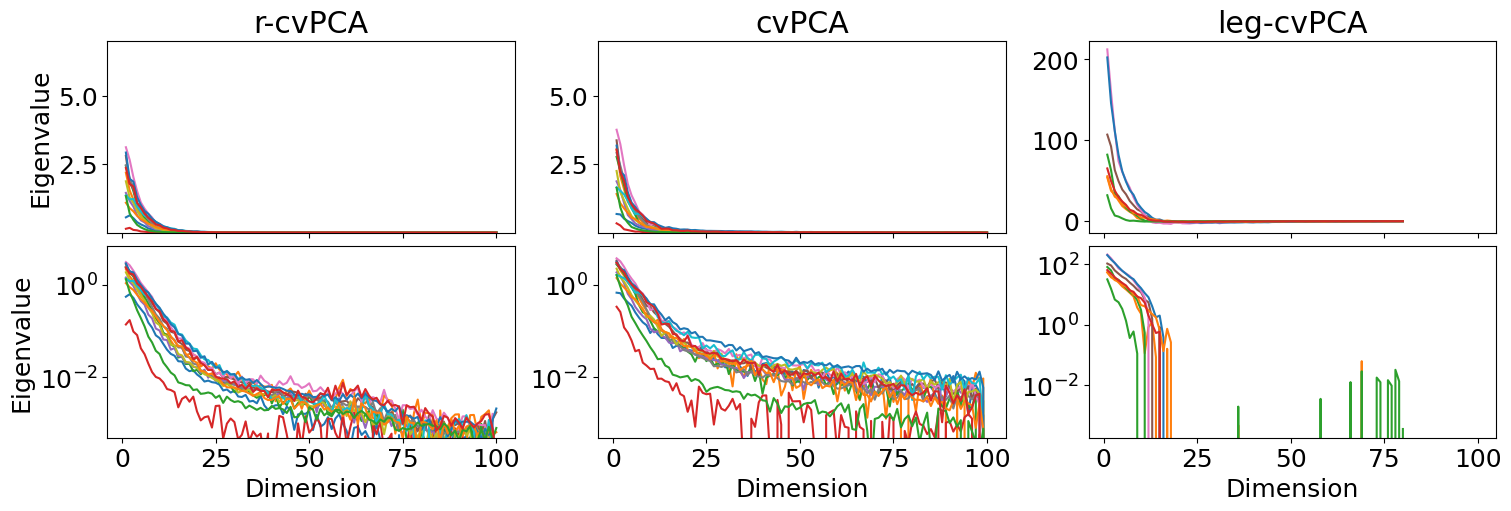

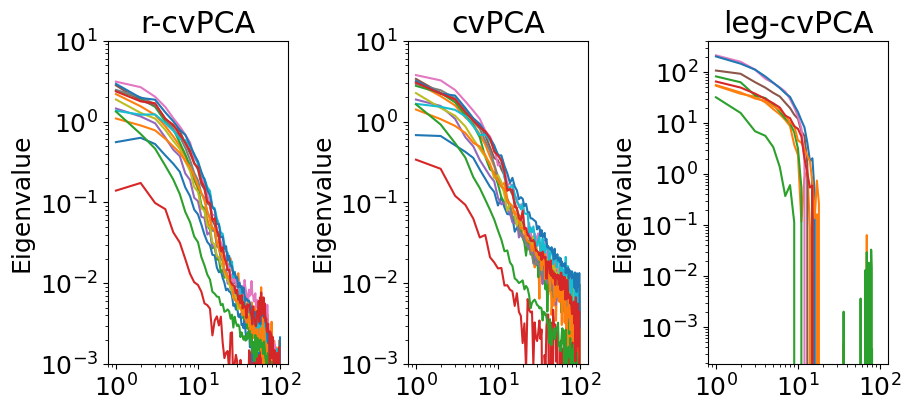

In [17]:
xscale = "linear"
yscale = "linear"

plot_leg_covariances = avg_saved_leg_covariances

isvd = 1
idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(2, 3, figsize=(15, 5), layout="constrained", sharex=True)
ax[0, 0].plot(idims, avg_reg_covariances[isvd].T)
ax[0, 1].plot(idims, avg_org_covariances[isvd].T)
ax[0, 2].plot(idims, plot_leg_covariances[isvd].T)
ax[1, 0].plot(idims, avg_reg_covariances[isvd].T)
ax[1, 1].plot(idims, avg_org_covariances[isvd].T)
ax[1, 2].plot(idims, plot_leg_covariances[isvd].T)
ax[0, 0].set_title("r-cvPCA")
ax[0, 1].set_title("cvPCA")
ax[0, 2].set_title("leg-cvPCA")
ax[0, 0].set_xscale("linear")
ax[0, 1].set_xscale("linear")
ax[0, 2].set_xscale("linear")
ax[0, 0].set_yscale("linear")
ax[0, 1].set_yscale("linear")
ax[0, 2].set_yscale("linear")
ax[1, 0].set_xscale("linear")
ax[1, 1].set_xscale("linear")
ax[1, 2].set_xscale("linear")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")
ax[1, 2].set_yscale("log")
ax[1, 0].set_xlabel("Dimension")
ax[1, 1].set_xlabel("Dimension")
ax[1, 2].set_xlabel("Dimension")
ax[0, 0].set_ylabel("Eigenvalue")
ax[1, 0].set_ylabel("Eigenvalue")
ax[0, 0].set_ylim(5e-4, 7e0)
ax[0, 1].set_ylim(5e-4, 7e0)
# ax[0, 2].set_ylim(5e-4, 7e0)
ax[1, 0].set_ylim(5e-4, 7e0)
ax[1, 1].set_ylim(5e-4, 7e0)
# ax[1, 2].set_ylim(5e-4, 7e0)
plt.show()

idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(9, 4), layout="constrained", sharex=True)
ax[0].plot(idims, avg_reg_covariances[isvd].T)
ax[1].plot(idims, avg_org_covariances[isvd].T)
ax[2].plot(idims, plot_leg_covariances[isvd].T)
ax[0].set_title("r-cvPCA")
ax[1].set_title("cvPCA")
ax[2].set_title("leg-cvPCA")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_ylabel("Eigenvalue")
ax[1].set_ylabel("Eigenvalue")
ax[2].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
# ax[2].set_ylim(1e-3, 1e1)
plt.show()

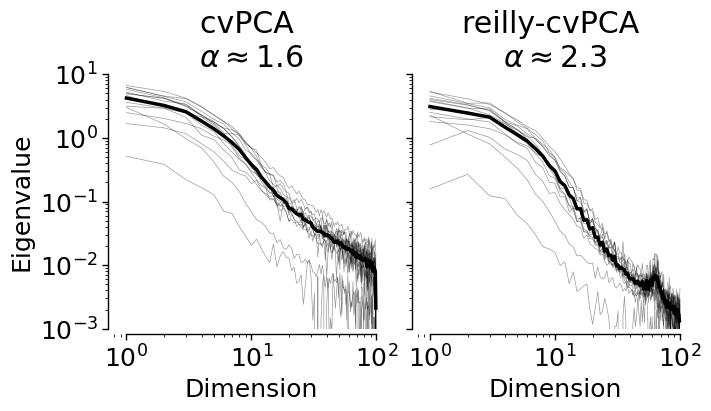

In [95]:
idims = np.arange(num_bins) + 1

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="constrained", sharex=True, sharey=True)
ax[0].plot(idims, avg_org_covariances[isvd].T, color="k", alpha=0.4, linewidth=0.5)
ax[1].plot(idims, avg_reg_covariances[isvd].T, color="k", alpha=0.4, linewidth=0.5)
ax[0].plot(idims, np.mean(avg_org_covariances[isvd], axis=0), color="k", linewidth=2.5)
ax[1].plot(idims, np.mean(avg_reg_covariances[isvd], axis=0), color="k", linewidth=2.5)
ax[0].set_title("cvPCA \n" + r"$\alpha \approx 1.6$")
ax[1].set_title("reilly-cvPCA \n" + r"$\alpha \approx 2.3$")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlabel("Dimension")
ax[1].set_xlabel("Dimension")
ax[0].set_ylabel("Eigenvalue")
# ax[1].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
format_spines(
    ax[0],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)
format_spines(
    ax[1],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)

figure_path = registry.registry_paths.figure_path / "cvpca" / f"compare_cvPCA_rcvPCA"
save_figure(fig, figure_path)
plt.show()

In [ ]:
from typing import Optional, Dict, Any
import pickle
from _old_vrAnalysis import tracking
from _old_vrAnalysis import analysis


def get_legacy_cvpca(
    session: B2Session,
    dist_step: float = 1.0,
    smooth: float = 0.1,
    cutoffs: tuple = (0.4, 0.7),
    maxcutoffs: Optional[tuple] = None,
) -> Dict[str, Any]:
    """
    Get original cvPCA data computed with the legacy old_VrAnalysis code from saved pickle files.
    
    This function loads the pre-computed cvPCA data that was saved by the old variance_structure.py
    scripts. The data is organized by mouse, so it finds the session within the mouse's saved data.
    
    Parameters
    ----------
    session : B2Session
        Session to get cvPCA data for
    dist_step : float, default=1.0
        Distance step used in the original analysis (must match saved data)
    smooth : float, default=0.1
        Smoothing width used in the original analysis (must match saved data)
    cutoffs : tuple, default=(0.4, 0.7)
        Reliability cutoffs used in the original analysis (must match saved data)
    maxcutoffs : tuple, optional
        Max cutoffs used in the original analysis (must match saved data)
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_by_env_all': List of cvPCA spectra for each environment (all cells)
        - 'cv_by_env_rel': List of cvPCA spectra for each environment (reliable cells)
        - 'cv_across_all': cvPCA spectrum for concatenated environments (all cells)
        - 'cv_across_rel': cvPCA spectrum for concatenated environments (reliable cells)
        - 'session_idx': Index of this session in the saved data
        - 'session_name': Name of this session
        - 'all_data': Full spectra_data dictionary (for reference)
    """
    # Convert B2Session to old session format to get session name
    vrexp = session.to_old_session()
    session_name = vrexp.sessionPrint()
    
    # Get mouse name
    mouse_name = session.mouse_name
    
    # Create tracker and placeCellMultiSession to access saveDirectory
    track = tracking.tracker(mouse_name)
    pcm = analysis.placeCellMultiSession(track, autoload=False)
    
    # Path to saved spectra data
    spectra_file = pcm.saveDirectory("temp") / f"{mouse_name}_spectra_data.pkl"
    
    if not spectra_file.exists():
        raise FileNotFoundError(
            f"Legacy cvPCA data not found at {spectra_file}. "
            f"Run the old variance_structure.py scripts first to generate this data."
        )
    
    # Load the saved data
    with open(spectra_file, "rb") as f:
        spectra_data = pickle.load(f)
    
    # Find this session in the saved data
    try:
        session_idx = spectra_data["names"].index(session_name)
    except ValueError:
        available_sessions = "\n".join(spectra_data["names"])
        raise ValueError(
            f"Session '{session_name}' not found in saved data for mouse '{mouse_name}'. "
            f"Available sessions:\n{available_sessions}"
        )
    
    # Extract cvPCA data for this session
    result = {
        "cv_by_env_all": spectra_data["cv_by_env_all"][session_idx],
        "cv_by_env_rel": spectra_data["cv_by_env_rel"][session_idx],
        "cv_across_all": spectra_data["cv_across_all"][session_idx],
        "cv_across_rel": spectra_data["cv_across_rel"][session_idx],
        "session_idx": session_idx,
        "session_name": session_name,
        "all_data": spectra_data,  # Keep full data for reference
    }
    
    return result

In [57]:
from dimensionality_manuscript.workflows.compare_old_cvpca import cvpca_integrated_comparison

spks_type = "oasis"
num_bins = 100

session = sessiondb.iter_sessions(imaging=True)[14]
session_name = session.session_print()

results = cvpca_integrated_comparison(
    session=session,
    spks_type=spks_type,
    num_bins=num_bins,
    smooth_width = None,
    normalize=False,
    center=True,
    shuffle_fraction=0.5,
)

legacy_result = get_legacy_cvpca(session)

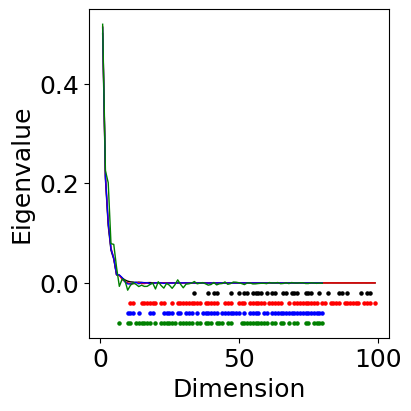

In [60]:
env_idx = results["best_env_idx"]
num_org = len(results["org_covariances"])
num_leg = len(results["leg_covariances"])
num_true_leg = len(results["true_leg_covariances"])
num_saved_leg = len(legacy_result["cv_by_env_all"][env_idx])

neg_org = np.where(results["org_covariances"] < 0)[0] + 1
neg_leg = np.where(results["leg_covariances"] < 0)[0] + 1
neg_true_leg = np.where(results["true_leg_covariances"] < 0)[0] + 1
neg_saved_leg = np.where(legacy_result["cv_by_env_all"][env_idx] < 0)[0] + 1

xorg = range(1, num_org + 1)
xleg = range(1, num_leg + 1)
xtrue_leg = range(1, num_true_leg + 1)
xsaved_leg = range(1, num_saved_leg + 1)
norm = lambda x: x / np.sum(x)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax.plot(xorg, norm(results["org_covariances"]), color="k", linewidth=1.0)
ax.plot(xleg, norm(results["leg_covariances"]), color="r", linewidth=1.0)
ax.plot(xtrue_leg, norm(results["true_leg_covariances"]), color="b", linewidth=1.0)
ax.plot(xsaved_leg, norm(legacy_result["cv_by_env_all"][env_idx]), color="g", linewidth=1.0)
ax.scatter(neg_org, -0.02*np.ones(len(neg_org)), color="k", s=5)
ax.scatter(neg_leg, -0.04*np.ones(len(neg_leg)), color="r", s=5)
ax.scatter(neg_true_leg, -0.06*np.ones(len(neg_true_leg)), color="b", s=5)
ax.scatter(neg_saved_leg, -0.08*np.ones(len(neg_saved_leg)), color="g", s=5)
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim(1e-6, 1e0)
ax.set_xlabel("Dimension")
ax.set_ylabel("Eigenvalue")
plt.show()

In [28]:
def plot(state):
    result = results[state["show"]]
    reference = results[state["reference"]]

    result = result / np.sum(result)
    reference = reference / np.sum(reference)

    num_dims = len(result)
    idims = np.arange(num_dims) + 1

    ref_dims = len(reference)
    ref_idims = np.arange(ref_dims) + 1

    neg_result = np.where(result < 0)[0] + 1
    neg_reference = np.where(reference < 0)[0] + 1

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(idims, result, color="k", linewidth=1.0)
    ax.plot(ref_idims, reference, color="r", linewidth=1.0)
    ax.scatter(neg_result, -0.04*np.ones(len(neg_result)), color="k", s=5)
    ax.scatter(neg_reference, -0.06*np.ones(len(neg_reference)), color="r", s=5)
    ax.set_xscale(state["xscale"])
    ax.set_yscale(state["yscale"])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Eigenvalue")
    return fig

viewer = make_viewer(plot)
viewer.add_selection("xscale", options=["linear", "log"])
viewer.add_selection("yscale", options=["linear", "log"])
viewer.add_selection("show", options=list(results.keys()))
viewer.add_selection("reference", options=list(results.keys()))
viewer.show()

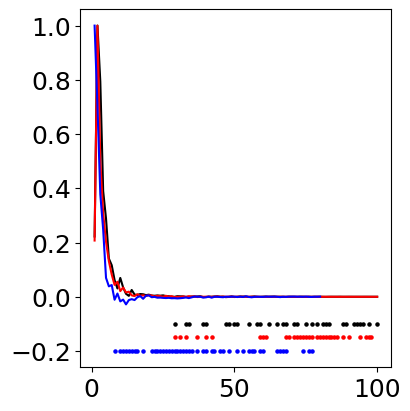

In [40]:
from matplotlib import pyplot as plt

def relative(data):
    return data / np.max(data)

new = new_result["org_smooth_covariances"]
new_smooth = new_result_smooth["org_smooth_covariances"]
old4new = old_from_new_result["cv_by_env"][0]   

negs_new = np.where(new < 0)[0]
negs_new_smooth = np.where(new_smooth < 0)[0]
# negs_old = np.where(old < 0)[0]
negs_old4new = np.where(old4new < 0)[0]

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax.plot(range(1, 101), relative(new), c='k')
ax.plot(range(1, 101), relative(new_smooth), c='r')
# ax.plot(range(1, 81), relative(old), c='r')
ax.plot(range(1, 81), relative(old4new), c='b')
ax.scatter(1 + negs_new, -0.1*np.ones(len(negs_new)), c='k', s=5)
ax.scatter(1 + negs_new_smooth, -0.15*np.ones(len(negs_new_smooth)), c='r', s=5)
# ax.scatter(1 + negs_old, -0.15*np.ones(len(negs_old)), c='r', s=5)
ax.scatter(1 + negs_old4new, -0.2*np.ones(len(negs_old4new)), c='b', s=5)
plt.show()